In [3007]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import ipywidgets as widgets
from ipywidgets import interact,interactive,fixed
import math
import pandas as pd

## Initial Parameters

In [3834]:
# the amount of days
n = 300

# restaurant names
rest_names = ["Italian", "Cafe", "Sushi"]

# the list of restaurant means 
rest_means = [5, 4.0, 3.0]

# the list of restaurant standard deviations
rest_std = [0.5, 0.25, 3.0]

## Functions

In [3450]:
def plot_distributions(names, means, std):
    '''A function that plots the distribution of each restaurant'''
    
    size= 100000
    
    dis_list = []
    
    for i in range(len(means)):
        distribution = np.random.normal(means[i], std[i], size = size)
        dis_list.append(distribution)
       
    plot = sns.displot(dis_list, legend = False)
    
    plt.legend(title = 'Restaurants', bbox_to_anchor=(1.75,0.0) ,loc="lower right" ,labels=list(reversed(names)))
    
    return plt.show(plot)

In [2345]:
def explore_only(rewards, n):
    '''The first strategy: explore only. We try every restaurant given - the same amount of times.'''
    
    # a list that records the total rewards we receive
    total_rewards = []
    
    # a list that records the total choices (restaurants) we made
    choices = []
    
    for day in range(n):
        # we choose one of the restaurants with an equal probability on that given day
        restaurant_chosen = np.random.choice(np.arange(0,len(rewards)), size = 1, p=([1/len(rewards)]*len(rewards)))[0]
        
        # we put our choice in a list
        choices.append(restaurant_chosen)
        
        # we put the reward in the list
        total_rewards.append(rewards[restaurant_chosen][day])
    
    return total_rewards, choices
    
        

In [3452]:
def exploitation_only(rewards, n):
    '''The second strategy: exploit only. We try every restaurant first and depending on the choice, we continue to exploit it.'''
    day_count = 0 
    
    total_rewards = []
    
    choices = []
    
    for restaurant in range(0,len(rewards)):
        # we explore every restaurant once and keep note of the quality
        total_rewards.append(rewards[restaurant][day_count])
        # we append our choice to the list
        choices.append(restaurant)
        
        day_count += 1
        
    # we pick the highest value
    highest_value = total_rewards.index(max(total_rewards))
    
    
    for i in range(len(rewards), n):
        # we exploit the highest value so far
        total_rewards.append(rewards[highest_value][day_count])
        # we record our choice
        choices.append(highest_value)
        day_count +=1
    
    return highest_value, total_rewards, choices

## Efficient Algorithms

In [3469]:
def epsilon_greedy(rewards, n, epsilon):
    
    day_count = 0
    
    # list holding the quality of each visit that we receive when going to the restaurant
    total_rewards = []
    
    # list holding the restaurant choice that we made
    choices = []
    
    # list holding the quality means of the restaurants, continuously updated
    mean_rewards = []
    
    # list holding the quality sum for each restaurant
    sum_rewards = []
    
    # again we explore every single restaurant once
    for r in range(len(rewards)):
        # we first get the reward for every restaurant on a given day
        total_rewards.append(rewards[r][day_count])
        # we record our choice
        choices.append(r)
        # we record our choice in the mean list 
        mean_rewards.append(rewards[r][day_count])
        # we sum the rewards
        sum_rewards.append(rewards[r][day_count])
        # we increase the day 
        day_count += 1
    
    for i in range(len(rewards),n):
        
        # we get the highest mean so far
        highest_value = mean_rewards.index(max(mean_rewards))
        
        # we decide whether to explore/exploit
        decision = np.random.choice(["explore", "exploit"], size = 1, p= (epsilon,1-epsilon))
        
        # depending on the choice we explore or exploit and update the mean 
        if decision[0] == "exploit":
            
            total_rewards.append(rewards[highest_value][day_count])
            
            choices.append(highest_value)
            
            sum_rewards[highest_value] += rewards[highest_value][day_count]
            
            mean_rewards[highest_value] =  (sum_rewards[highest_value]) / choices.count(highest_value)
            
            day_count += 1
        
        else:
            
             # we randomly pick a restaurant that is not equal to the highest value; we explore!
            draw = int(np.random.choice(np.arange(0,len(rewards))))
            
            # in case we pick the current highest value, we continue to draw until we have another
            while draw == highest_value:
                draw = int(np.random.choice(np.arange(0,len(rewards))))
                
            total_rewards.append(rewards[draw][day_count])
            
            choices.append(draw)
            
            sum_rewards[draw] += rewards[draw][day_count]
            
            mean_rewards[draw] =  (sum_rewards[draw] + rewards[draw][day_count]) / choices.count(draw)
            
            day_count += 1
        
    return total_rewards, choices
            

In [3488]:
def upper_confidence_bounds(rewards, n):
    
    amount_r = len(rewards)
    
    res_selected = []
    
    numbers_of_selections = [0] * amount_r
    
    sums_of_rewards = [0] * amount_r

    rewards_list = []
    
    total_reward = 0
    
    # loop that runs over all the days
    for n in range(0, n):
        
        # we initialize the value of quality for a restaurant to 0 -> why exactly?
        res = 0
    
        # we set a maximum upper bound to 0 -> why exactly
        max_upper_bound = 0
        
        # loop that goes through every restaurant and calculates the upper bound
        for i in range(0, amount_r):
            
            # in case that there exists a value, we calculate the mean + the delta
            if (numbers_of_selections[i] > 0):
            
                # mean of a restaurant 
                average_reward = sums_of_rewards[i] / numbers_of_selections[i]
                
                
                delta_i = np.sqrt((2*np.log(n))/numbers_of_selections[i])
            
                # upper bound 
                upper_bound = average_reward + delta_i
                
            else:
                # we set the upper bound to infinite
                upper_bound = 1e400

                
                # in case that the upper bound is bigger than the max_upper_bound, we set the max_upper bound to infinite as well
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                
                # we set the add to the current index
                res = i
            
        # we append the current index to the selected restaurants
        res_selected.append(res)
    
        # we increase the amount of selections by one
        numbers_of_selections[res] = numbers_of_selections[res] + 1
    
        # we set our reward equal to the day and chosen restaurant
        reward = rewards[res][n]
        
        rewards_list.append(reward)
        
        # we calculate the sum of the reward for the given restaurant    
        sums_of_rewards[res] = sums_of_rewards[res] + reward
    
    return rewards_list, res_selected
    

In [3648]:
def thompson_sampling(rewards, n):
    
    # holds the current day
    current_day = 0
    
    # list holding the restaurant choice that we made
    choices = []
    
    # amount of restaurants
    amount_r = len(rewards)
    
    # list of rewards
    rewards_list = []
    
    # holds the list of the means for the restaurants 
    list_of_means = [0] * amount_r
    
    # list of random samples
    list_of_rand = [0] * amount_r
    
    # a list that holds the amount of visits for each restaurant
    sum_of_means = [0] * amount_r
    
    # list of visits
    
    for day in range(0,n):
        
        for res in range(0, amount_r):
            
            var = (1/(100**2) + choices.count(res))**(-1)
        
            #print(f"the current var is {var}")
            
            # we calculate the mean for each restaurant
            list_of_means[res] =  var * sum_of_means[res]
            
            #print(f"the current mean is {list_of_means[res]}")
            
            # we draw a random sample from that distribution 
            random_sample = np.random.normal(list_of_means[res], var)
            
            # we append it to our list of random samples
            list_of_rand[res] = random_sample
            
            #print(f"the random sample is {list_of_rand[res]}")
        
        # we get the index for the highest 
        highest_value = np.argmax(list_of_rand)
        
        #print(f"the chosen res is {highest_value}")
        
        # we append our choice
        choices.append(highest_value)
        
        # we update the sum of means
        sum_of_means[highest_value] += rewards[highest_value][day]
        
        # we append the reward
        rewards_list.append(rewards[highest_value][day])
        
        current_day += 1
        
        #print("\n")
    
    return rewards_list, choices
        

## Exploitation vs Exploration only 

Let us first observe the distribution of the restaurant qualities!

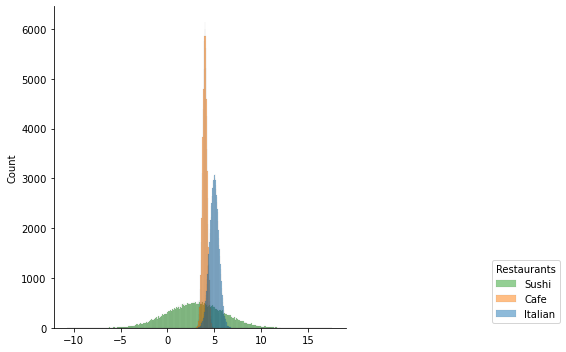

In [3835]:
plot_distributions(rest_names, rest_means, rest_std)

Now, we do the first round of choices using the exploit and explore only method. <br>
Depending on our choice in the exploit, one of the methods will win

In [3863]:
rewards = [[np.random.normal(rest_means[restaurant], rest_std[restaurant]) for day in range(0,n)] for restaurant in range(0,len(rest_means))]

In [3864]:
explore_rewards, explore_choices = explore_only(rewards, n)

In [3865]:
chosen_r, exploit_rewards, exploit_choices = exploitation_only(rewards, n)

In [3866]:
X = np.arange(1, n+1, 1)

exploration = np.cumsum(explore_rewards)

exploitation = np.cumsum(exploit_rewards)

#thompson = np.cumsum(thompson_rewards)

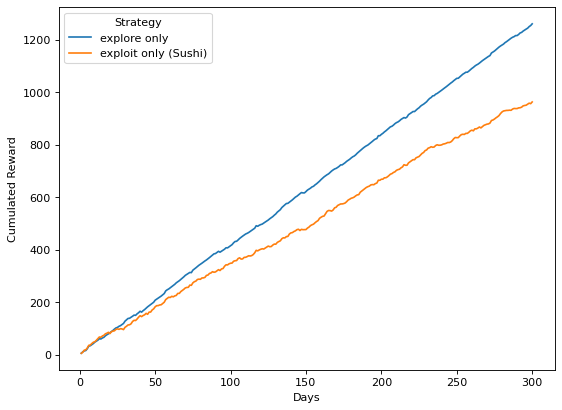

In [3867]:
figure(figsize=(8, 6), dpi=80)

plt.plot(X, exploration, label = "explore only")

plt.plot(X, exploitation, label  = f"exploit only ({rest_names[chosen_r]})")

#plt.plot(X, thompson, label = "thompson")

plt.xlabel("Days")

plt.ylabel("Cumulated Reward")

plt.legend(title = "Strategy")

In [3868]:
explor_total = []
exploit_total = []
#thompson_total = []

for i in range(200):
    
    rewards = [[np.random.normal(rest_means[restaurant], rest_std[restaurant]) for day in range(0,n)] for restaurant in range(0,len(rest_means))]
    
    optimal_str = np.sum(rewards[0])
    
    # one simulation round
    chosen_r, exploit_rewards, exploit_choices = exploitation_only(rewards, n)
    explore_rewards, explore_choices = explore_only(rewards, n)
    #thompson_rewards, thompson_choices = thompson_sampling(rewards, n)
    
    # the sum of each simulation round
    exploration = np.sum(explore_rewards)
    exploitation = np.sum(exploit_rewards)
    #thompson = np.sum(thompson_rewards)
    
    # we append every result to the corresponding list 
    explor_total.append(exploration)
    exploit_total.append(exploitation)
    #thompson_total.append(thompson)
    opt_str.append(optimal_str)

In [3869]:
print(f"The average regret for explore only is {np.mean(opt_str) - np.mean(explor_total)}")
print(f"The average regret for exploit only is {np.mean(opt_str) - np.mean(exploit_total)}")
#print(f"The average regret for thompson only is {np.mean(opt_str) - np.mean(thompson_total)}")

The average regret for explore only is 1798.5221531519483
The average regret for exploit only is 1690.5543713706359


## Exploitation only vs Exploration only vs Epsilon Greedy 

In [3870]:
rewards = [[np.random.normal(rest_means[restaurant], rest_std[restaurant]) for day in range(0,n)] for restaurant in range(0,len(rest_means))]

In [3871]:
# we first instantiate our epsilon
eps = 0.1

In [3872]:
chosen_r, exploit_rewards, exploit_choices = exploitation_only(rewards, n)

In [3873]:
explore_rewards, explore_choices = explore_only(rewards, n)

In [3874]:
epsilon_rewards, epsilon_choices = epsilon_greedy(rewards, n, eps)

In [3875]:
X = np.arange(1, n+1, 1)

exploration = np.cumsum(explore_rewards)

exploitation = np.cumsum(exploit_rewards)

epsilon = np.cumsum(epsilon_rewards)


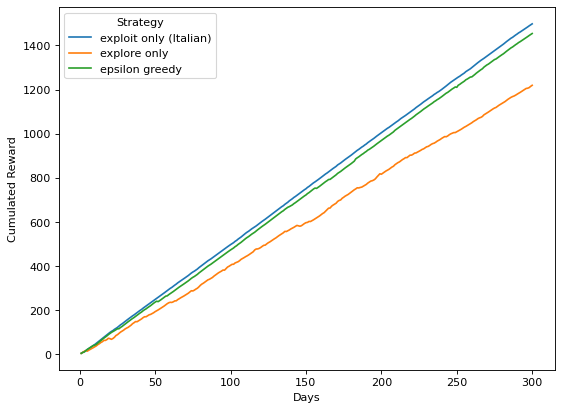

In [3876]:
figure(figsize=(8, 6), dpi=80)

plt.plot(X, exploitation, label = f"exploit only ({rest_names[chosen_r]})")

plt.plot(X, exploration, label = "explore only")

plt.plot(X, epsilon, label = "epsilon greedy")

plt.xlabel("Days")

plt.ylabel("Cumulated Reward")

plt.legend(title = "Strategy")

We observe that the epsilon greedy is the best performing algorithm unless the exploit only chooses the Italian restaurant.

In [3878]:
explor_total = []
exploit_total = []
epsilon_total = []
opt_str = []

for i in range(200):
    
    rewards = [[np.random.normal(rest_means[restaurant], rest_std[restaurant]) for day in range(0,n)] for restaurant in range(0,len(rest_means))]
    
    optimal_str = np.sum(rewards[0])
    
    # one simulation round
    chosen_r, exploit_rewards, exploit_choices = exploitation_only(rewards, n)
    explore_rewards, explore_choices = explore_only(rewards, n)
    epsilon_rewards, epsilon_choices = epsilon_greedy(rewards, n, eps)
    #ucb_rewards, ucb_choices = upper_confidence_bounds(rewards, n)
    
    # the sum of each simulation round
    exploration = np.sum(explore_rewards)
    exploitation = np.sum(exploit_rewards)
    epsilon = np.sum(epsilon_rewards)
    #ucb = np.sum(ucb_rewards)
    
    # we append every result to the corresponding list 
    explor_total.append(exploration)
    exploit_total.append(exploitation)
    epsilon_total.append(epsilon)
    opt_str.append(optimal_str)

In [3879]:
print(f"The average regret for explore only is {np.mean(opt_str) - np.mean(explor_total)}")
print(f"The average regret for exploit only is {np.mean(opt_str) - np.mean(exploit_total)}")
print(f"The average regret for epsilon only is {np.mean(opt_str) - np.mean(epsilon_total)}")

The average regret for explore only is 295.65463427809004
The average regret for exploit only is 173.11828932583012
The average regret for epsilon only is 52.24801125379554


## Exploitation only vs Exploration only vs Epsilon Greedy vs Upper Confidence Bounds

In [3880]:
# setting epsilon for epsilon greedy
e = 0.1

# choosing the amount of days 
n = 300

In order to show the impact of the Upper confidence Bounds, let us complicate our simulation a bit by giving Moritz the ability to explore more than just three restaurants. <br>


In [3881]:
new_rest_means = np.arange(1, 11, 1)

print(f"Moritz now has {len(new_rest_means)} restaurants to choose from.")
print(f"The highest quality restaurant is {np.max(new_rest_means)}")

Moritz now has 10 restaurants to choose from.
The highest quality restaurant is 10


We also change the Standard Deviation of each restaurant by a factor of the mean, to make them either wider or smaller.

In [2661]:
import ipywidgets as widgets
from IPython.display import display
d = 5
slider = widgets.IntSlider(min = 0, max = 100)
slider.value = d
slider.observe(on_change, names='value')
display(slider)

IntSlider(value=5)

In [3902]:
new_rest_std = [i*(d/100) for i in new_rest_means]

print(f"The standard deviation for the highest rated restaurant is {np.max(new_rest_std)}")

The standard deviation for the highest rated restaurant is 1.0


In [3903]:
new_rest_names = [str(i) for i in new_rest_means]

Let us understand the distribution of how difficult it will now be to make a greedy decision by looking at the distribution:

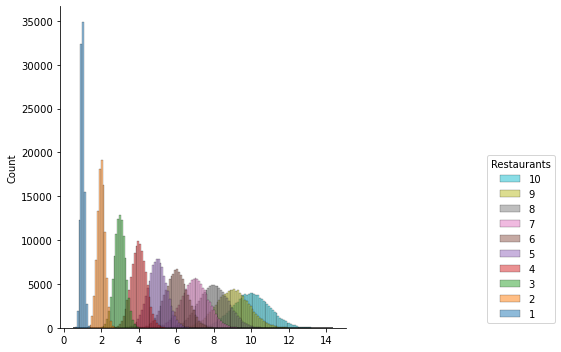

In [3904]:
plot_distributions(new_rest_names, new_rest_means, new_rest_std)

The bigger our d, the wider the distributions become. <br>
Since we now undestand the impact of the parameter d, let us see the impact on the simulations

In [3905]:
rewards = [[np.random.normal(new_rest_means[restaurant], new_rest_std[restaurant]) for day in range(0,n)] for restaurant in range(0,len(new_rest_means))]

In [3906]:
explore_rewards, explore_choices = explore_only(rewards, n)

In [3907]:
chosen_r, exploit_rewards, exploit_choices = exploitation_only(rewards, n)

In [3908]:
epsilon_rewards, epsilon_choices = epsilon_greedy(rewards, n, eps)

In [3909]:
ucb_rewards, ucb_choices = upper_confidence_bounds(rewards, n)

In [3910]:
X = np.arange(1, n+1, 1)

exploration = np.cumsum(explore_rewards)

exploitation = np.cumsum(exploit_rewards)

epsilon = np.cumsum(epsilon_rewards)

ucb = np.cumsum(ucb_rewards)

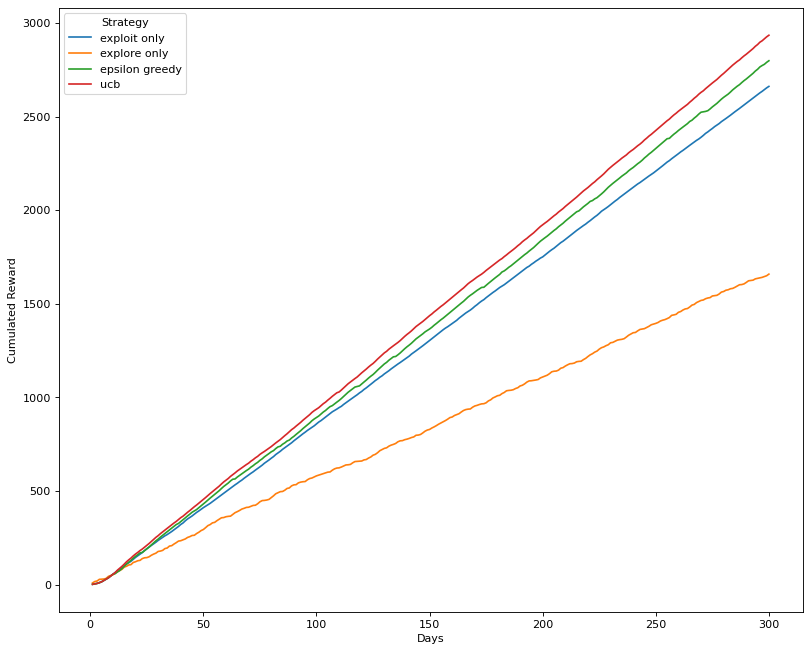

In [3911]:
figure(figsize=(12, 10), dpi=80)

plt.plot(X, exploitation, label = "exploit only")

plt.plot(X, exploration, label = "explore only")

plt.plot(X, epsilon, label = "epsilon greedy")

plt.plot(X, ucb, label = "ucb")

plt.xlabel("Days")

plt.ylabel("Cumulated Reward")

plt.legend(title = "Strategy")

Let us know simulate several runs after each other and calculate the average regret for each strategy

In [3912]:
explor_total = []
exploit_total = []
ucb_total = []
epsilon_total = []
opt_str = []

for i in range(200):
    
    rewards = [[np.random.normal(new_rest_means[restaurant], new_rest_std[restaurant]) for day in range(0,n)] for restaurant in range(0,len(new_rest_means))]
    optimal_str = np.sum(rewards[len(new_rest_means)-1])
    
    # one simulation round
    ucb_rewards, ucb_choices = upper_confidence_bounds(rewards, n)
    chosen_r, exploit_rewards, exploit_choices = exploitation_only(rewards, n)
    explore_rewards, explore_choices = explore_only(rewards, n)
    epsilon_rewards, epsilon_choices = epsilon_greedy(rewards, n, eps)
    
    # the sum of each simulation round
    exploration = np.sum(explore_rewards)
    exploitation = np.sum(exploit_rewards)
    epsilon = np.sum(epsilon_rewards)
    ucb = np.sum(ucb_rewards)
    
    # we append every result to the corresponding list 
    explor_total.append(exploration)
    exploit_total.append(exploitation)
    epsilon_total.append(epsilon)
    ucb_total.append(ucb)
    opt_str.append(optimal_str)

In [3913]:
print(f"The average regret for explore only is {np.mean(opt_str) - np.mean(explor_total)}")
print(f"The average regret for exploit only is {np.mean(opt_str) - np.mean(exploit_total)}")
print(f"The average regret for epsilon only is {np.mean(opt_str) - np.mean(epsilon_total)}")
print(f"The average regret for ucb only is {np.mean(opt_str) - np.mean(ucb_total)}")

The average regret for explore only is 1355.9177695877795
The average regret for exploit only is 137.46205783815822
The average regret for epsilon only is 206.48964537758184
The average regret for ucb only is 59.41380092423333


We observe that the UCB is performing even better than the rest, despite uncertainty

## The ultimate battle: Exploitation only vs Exploration only vs Epsilon Greedy vs Upper Confidence Bounds vs Thompson Sampling

In [3914]:
# setting epsilon for epsilon greedy
e = 0.1

# choosing the amount of days 
n = 300

In [3915]:
new_rest_means = np.arange(1, 21, 1)

print(f"Moritz now has {len(new_rest_means)} restaurants to choose from.")
print(f"The highest quality restaurant is {np.max(new_rest_means)}")

Moritz now has 20 restaurants to choose from.
The highest quality restaurant is 20


In [3753]:
import ipywidgets as widgets
from IPython.display import display
d = 5
slider = widgets.IntSlider(min = 0, max = 100)
slider.value = d
slider.observe(on_change, names='value')
display(slider)

IntSlider(value=5)

In [3916]:
new_rest_std = [i*(d/100) for i in new_rest_means]

print(f"The standard deviation for the highest rated restaurant is {np.max(new_rest_std)}")

The standard deviation for the highest rated restaurant is 15.2


In [3917]:
new_rest_names = [str(i) for i in new_rest_means]

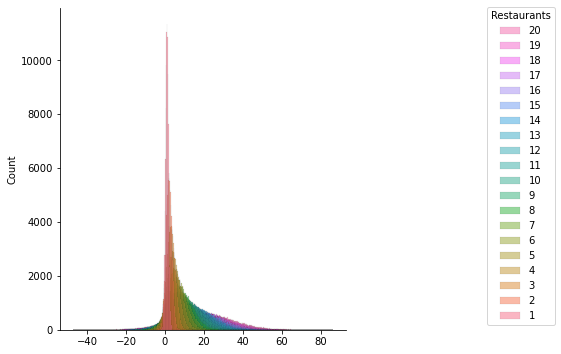

In [3918]:
plot_distributions(new_rest_names, new_rest_means, new_rest_std)

In [3927]:
rewards = [[np.random.normal(new_rest_means[restaurant], new_rest_std[restaurant]) for day in range(0,n)] for restaurant in range(0,len(new_rest_means))]

In [3928]:
explore_rewards, explore_choices = explore_only(rewards, n)

In [3929]:
chosen_r, exploit_rewards, exploit_choices = exploitation_only(rewards, n)

In [3930]:
epsilon_rewards, epsilon_choices = epsilon_greedy(rewards, n, eps)

In [3931]:
ucb_rewards, ucb_choices = upper_confidence_bounds(rewards, n)

In [3932]:
thompson_rewards, thompson_choices = thompson_sampling(rewards, n)

In [3933]:
X = np.arange(1, n+1, 1)

exploration = np.cumsum(explore_rewards)

exploitation = np.cumsum(exploit_rewards)

epsilon = np.cumsum(epsilon_rewards)

ucb = np.cumsum(ucb_rewards)

thompson = np.cumsum(thompson_rewards)

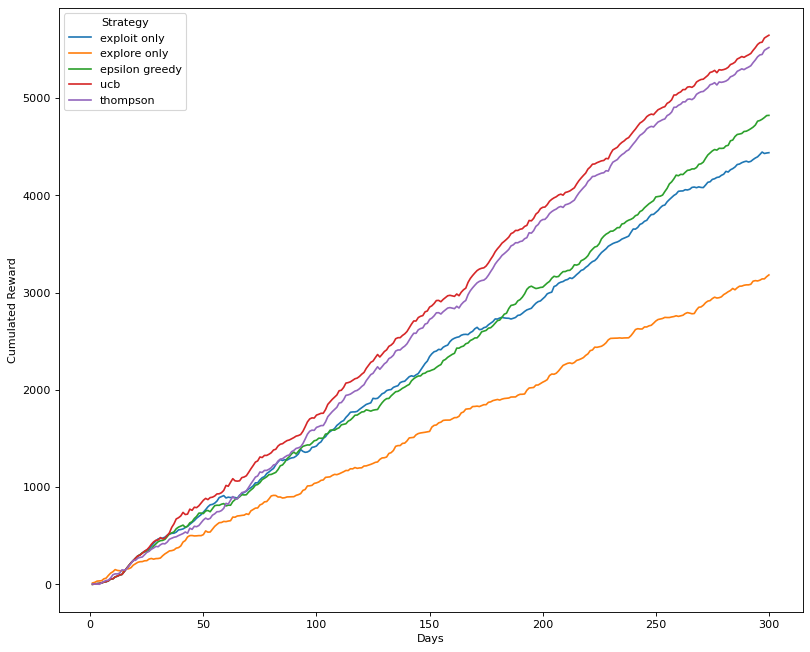

In [3934]:
figure(figsize=(12, 10), dpi=80)

plt.plot(X, exploitation, label = "exploit only")

plt.plot(X, exploration, label = "explore only")

plt.plot(X, epsilon, label = "epsilon greedy")

plt.plot(X, ucb, label = "ucb")

plt.plot(X, thompson, label = "thompson")

plt.xlabel("Days")

plt.ylabel("Cumulated Reward")

plt.legend(title = "Strategy")

In [3935]:
explor_total = []
exploit_total = []
ucb_total = []
epsilon_total = []
opt_str = []
thompson_total = []

for i in range(200):
    
    rewards = [[np.random.normal(new_rest_means[restaurant], new_rest_std[restaurant]) for day in range(0,n)] for restaurant in range(0,len(new_rest_means))]
    optimal_str = np.sum(rewards[len(new_rest_means)-1])
    
    # one simulation round
    ucb_rewards, ucb_choices = upper_confidence_bounds(rewards, n)
    chosen_r, exploit_rewards, exploit_choices = exploitation_only(rewards, n)
    explore_rewards, explore_choices = explore_only(rewards, n)
    epsilon_rewards, epsilon_choices = epsilon_greedy(rewards, n, eps)
    thompson_rewards, thompson_choices = thompson_sampling(rewards, n)
    
    # the sum of each simulation round
    exploration = np.sum(explore_rewards)
    exploitation = np.sum(exploit_rewards)
    epsilon = np.sum(epsilon_rewards)
    ucb = np.sum(ucb_rewards)
    thompson = np.sum(thompson_rewards)
    
    # we append every result to the corresponding list 
    explor_total.append(exploration)
    exploit_total.append(exploitation)
    epsilon_total.append(epsilon)
    ucb_total.append(ucb)
    thompson_total.append(thompson)
    opt_str.append(optimal_str)

In [3936]:
print(f"The average regret for explore only is {np.mean(opt_str) - np.mean(explor_total)}")
print(f"The average regret for exploit only is {np.mean(opt_str) - np.mean(exploit_total)}")
print(f"The average regret for epsilon only is {np.mean(opt_str) - np.mean(epsilon_total)}")
print(f"The average regret for ucb only is {np.mean(opt_str) - np.mean(ucb_total)}")
print(f"The average regret for thompson only is {np.mean(opt_str) - np.mean(thompson_total)}")

The average regret for explore only is 2829.59672369364
The average regret for exploit only is 960.2591253443161
The average regret for epsilon only is 912.2984273258589
The average regret for ucb only is 738.8170207430167
The average regret for thompson only is 698.4082454809331


# We have a winner: Thompson Sampling